In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [4]:
# resources
!gdown --id 1I242ygNivRhYJ6kIEfvlAhg_2WMTgDDv
!unzip -qq SSDs.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I242ygNivRhYJ6kIEfvlAhg_2WMTgDDv
To: /content/SSDs.zip
100% 25.5M/25.5M [00:00<00:00, 36.5MB/s]


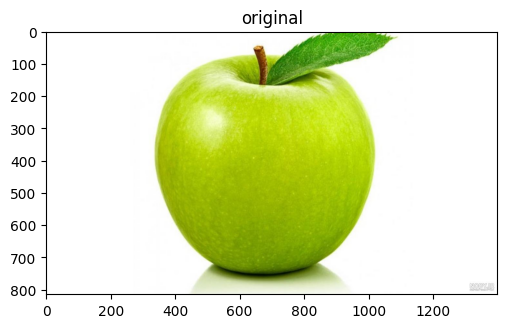

Running our Single Shot Detector on our image...


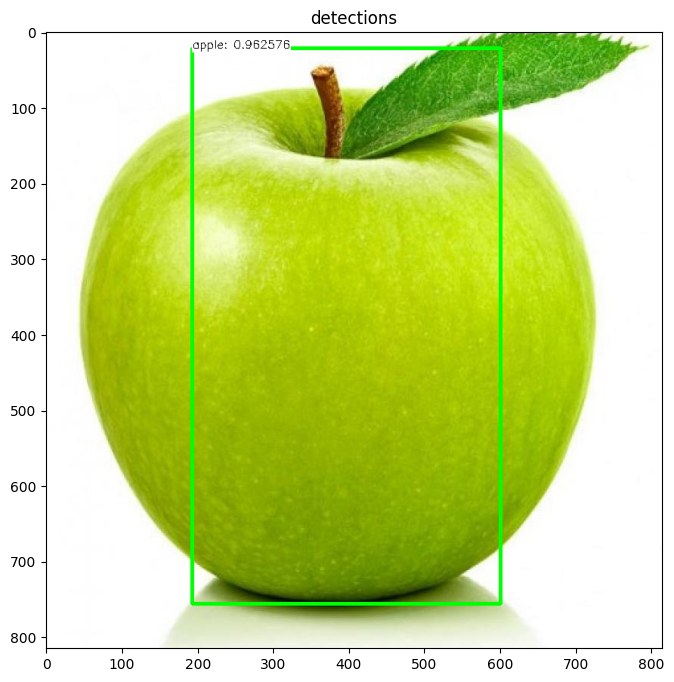

In [8]:
# Load our images
frame = cv2.imread('./images/1.jpg')
#frame = cv2.imread('./images/2.jpeg')

imshow("original", frame)

print("Running our Single Shot Detector on our image...")
# Make a copy of our loaded image
image = frame.copy()

# Set the widths and heights that are needed for input into our model
inWidth = 300
inHeight = 300
WHRatio = inWidth / float(inHeight)

# These are needed for our preprocessing of our image
inScaleFactor = 0.007843
meanVal = 127.5

# Point to the paths of our weights and  model architecture in a protocol buffer
prototxt = "SSDs/ssd_mobilenet_v1_coco.pbtxt"
weights = "SSDs/frozen_inference_graph.pb"

# Number of classes
num_classes = 90

# Probality Threshold
thr = 0.5

net = cv2.dnn.readNetFromTensorflow(weights, prototxt)

swapRB = True
classNames = { 0: 'background',
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus',
    7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant',
    13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat',
    18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear',
    24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag',
    32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard',
    37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove',
    41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle',
    46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
    51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
    56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
    61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
    67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
    75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
    86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush' }

# Create our input image blob required for input into our network
blob = cv2.dnn.blobFromImage(frame, inScaleFactor, (inWidth, inHeight), (meanVal, meanVal, meanVal), swapRB)
net.setInput(blob)

# Pass our input image/blob into the network
detections = net.forward()

# Crop frame if needed as we don't resize our input but take a square input
cols = frame.shape[1]
rows = frame.shape[0]

if cols / float(rows) > WHRatio:
    cropSize = (int(rows * WHRatio), rows)
else:
    cropSize = (cols, int(cols / WHRatio))

y1 = int((rows - cropSize[1]) / 2)
y2 = y1 + cropSize[1]
x1 = int((cols - cropSize[0]) / 2)
x2 = x1 + cropSize[0]
frame = frame[y1:y2, x1:x2]

cols = frame.shape[1]
rows = frame.shape[0]

# Iterate over every detection
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    # Once confidence is greater than the threshold we get our bounding box
    if confidence > thr:
        class_id = int(detections[0, 0, i, 1])

        xLeftBottom = int(detections[0, 0, i, 3] * cols)
        yLeftBottom = int(detections[0, 0, i, 4] * rows)
        xRightTop   = int(detections[0, 0, i, 5] * cols)
        yRightTop   = int(detections[0, 0, i, 6] * rows)

        # Draw our bounding box over our image
        cv2.rectangle(frame, (xLeftBottom, yLeftBottom), (xRightTop, yRightTop),
                      (0, 255, 0), 3)
        # Get our class names and put them on our image (using a white background)
        if class_id in classNames:
            label = classNames[class_id] + ": " + str(confidence)
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            yLeftBottom = max(yLeftBottom, labelSize[1])
            cv2.rectangle(frame, (xLeftBottom, yLeftBottom - labelSize[1]),
                                 (xLeftBottom + labelSize[0], yLeftBottom + baseLine),
                                 (255, 255, 255), cv2.FILLED)
            cv2.putText(frame, label, (xLeftBottom, yLeftBottom),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

# Show our detections
imshow("detections", frame , 8)